(tropical_fluxes)=o
# Energy and vapor fluxes in the tropical boundary layer

Stull Chapter 4.4.2 and 4.4.3 give equations for the turbulent heat and moisture fluxes.  In this notebook
we look at the closely related fluxes of moist static energy ($h_m$, defined in my thermodynamics notes) and latent heat

1.  What do the fluxes of sensible and latent heat look like for the tropical case?

1.  Drill down into the data using

    a.  Two dimensional histograms
    
    b.  images with normalized color pallettes

## Reading a netcdf file

1.  Fetch the netcdf file tropical.nc from my webserver (50 Mbytes)

In [1]:
from pathlib import Path
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
the_file = Path.home() / "Dropbox/phil_files/a405/data/tropical_subset.nc"
the_ds = xr.open_dataset(the_file)

Only download the data once -- set this to True if you need
this file, otherwise skip

In [2]:
the_temp = the_ds['TABS'][...].squeeze()
the_height=the_ds['z'][...].squeeze()
xvals=the_ds['x'][...].squeeze()
yvals=the_ds['y'][...].squeeze()
print(f"{the_height.shape=}")
the_press=the_ds['p'][...].squeeze()
the_press=the_press*100.  #convert to Pa
wvel=the_ds['W'][...].squeeze()  #m/s
qv=the_ds['QV'][...].squeeze()  #vapor g/kg
ql=the_ds['QN'][...].squeeze()  #liquid  g/kg
print(f"{ql.shape=}")

the_height.shape=(112,)
ql.shape=(112, 110, 100)


### How much liquid water is in the domain?

Text(0.5, 1.0, 'histogram of cloud lwc (g/kg)')

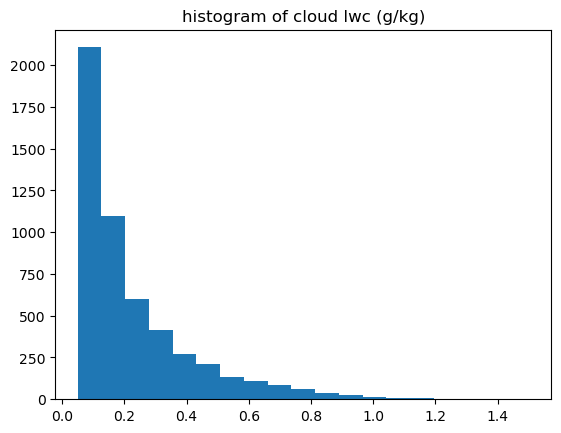

In [3]:
bins=np.linspace(0.05,1.5,20)
out=plt.hist(ql.data.flat,bins=bins)
plt.title('histogram of cloud lwc (g/kg)')

# Plotting three $h_m$ profiles

What does $h_m = c_p T + l_v q_v + gz$ look like in the boundary layer?

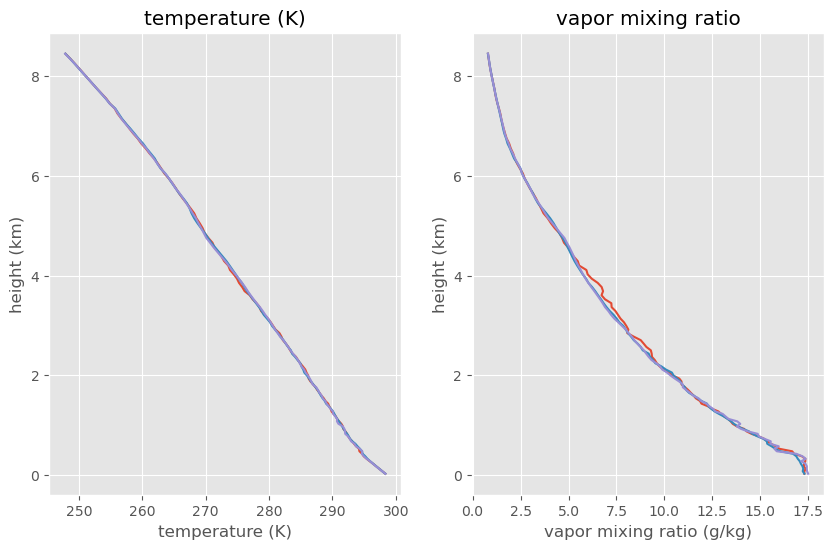

In [4]:
plt.style.use('ggplot')
meter2km=1.e-3
#
# three random columns
#
random_xy=[(10,20),(80,40),(25,75)]
fig,ax=plt.subplots(1,2,figsize=(10,6))
for x,y in random_xy:
    temp_profile=the_temp[:,y, x]
    qv_profile=qv[:,y, x]
    out=ax[0].plot(temp_profile,the_height*meter2km) 
    out=ax[1].plot(qv_profile,the_height*meter2km) 
out=ax[0].set(xlabel='temperature (K)',ylabel='height (km)',title='temperature (K)')
out=ax[1].set(xlabel='vapor mixing ratio (g/kg)',ylabel='height (km)',title='vapor mixing ratio')

### moist static energy (J/kg)

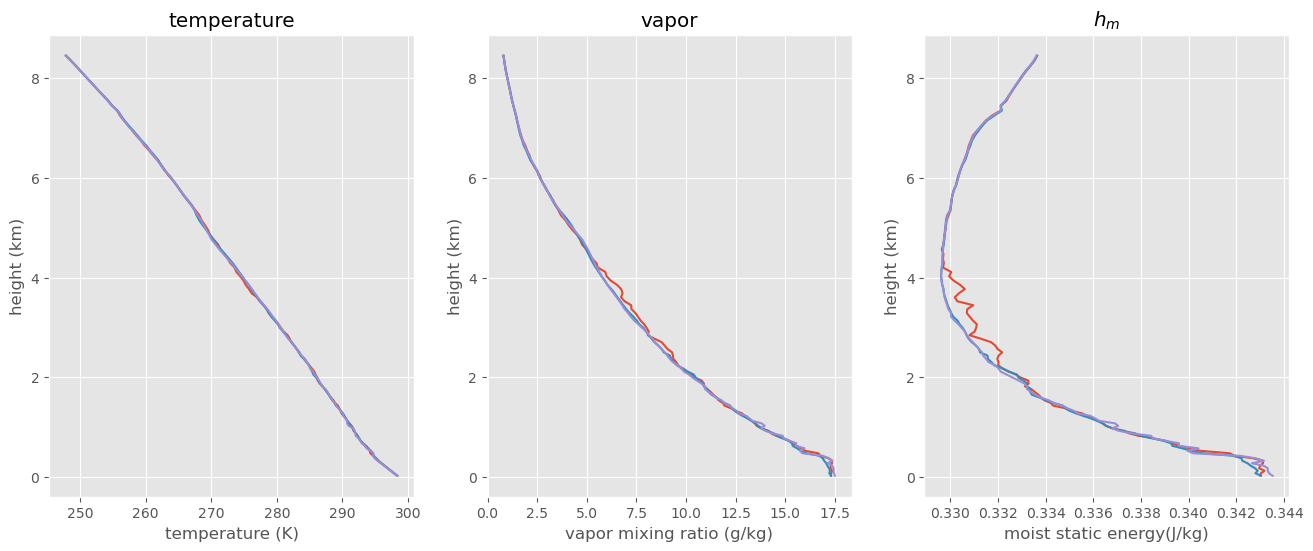

In [5]:
lv=2.5e6
g=9.8
cpd=1004.
g2kg=1.e-3
#
# three random columns
#
random_xy=[(10,20),(80,40),(25,75)]
fig,ax=plt.subplots(1,3,figsize=(16,6))
for x,y in random_xy:
    temp_profile=the_temp[:,y, x]
    qv_profile=qv[:,y, x]
    hm_profile = cpd*temp_profile + lv*qv_profile*1.e-3 + g*the_height
    out=ax[0].plot(temp_profile,the_height*meter2km) 
    out=ax[1].plot(qv_profile,the_height*meter2km) 
    out=ax[2].plot(hm_profile*1.e-6,the_height*meter2km) 
out=ax[0].set(xlabel='temperature (K)',ylabel='height (km)',title='temperature')
out=ax[1].set(xlabel='vapor mixing ratio (g/kg)',ylabel='height (km)',title='vapor')
out=ax[2].set(xlabel='moist static energy(J/kg)',ylabel='height (km)',title='$h_m$')

### zoom in on bottom 1 km

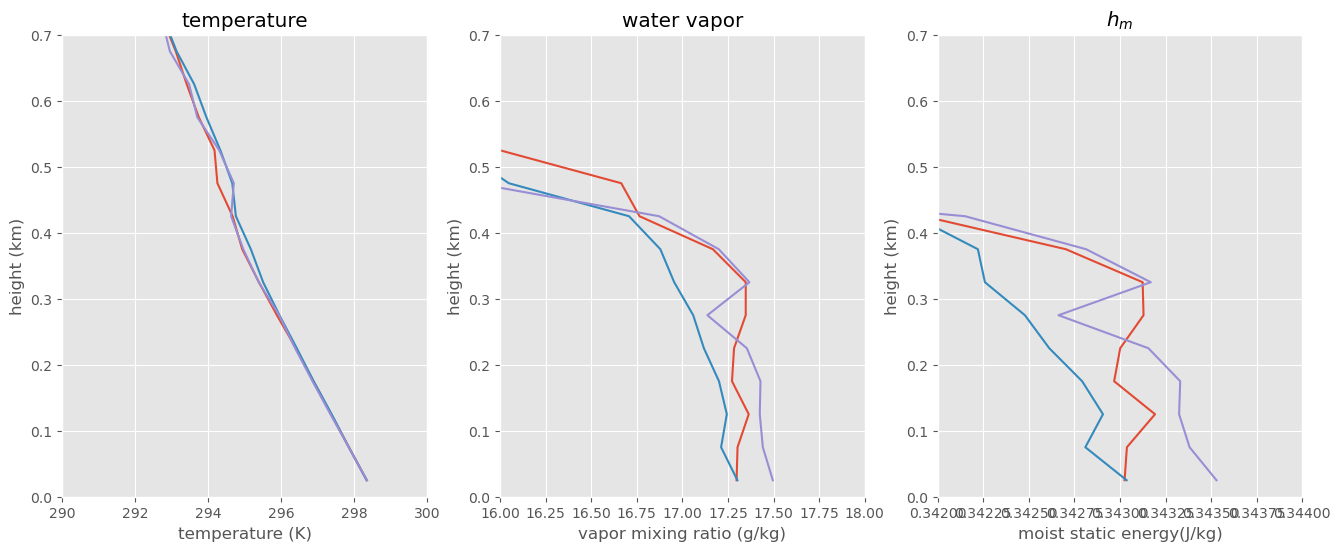

In [6]:
%matplotlib inline
#
# plot 3 arbitrary columns
#
from matplotlib import pyplot as plt
meter2km=1.e-3
lv=2.5e6
g=9.8
cpd=1004.
random_xy=[(10,20),(80,40),(25,75)]
fig,ax=plt.subplots(1,3,figsize=(16,6))
for x,y in random_xy:
    temp_profile=the_temp[:,y, x]
    qv_profile=qv[:,y, x]
    hm_profile = cpd*temp_profile + lv*qv_profile*g2kg + g*the_height
    out=ax[0].plot(temp_profile,the_height*meter2km) 
    out=ax[1].plot(qv_profile,the_height*meter2km) 
    out=ax[2].plot(hm_profile*1.e-6,the_height*meter2km) 
out=ax[0].set(xlabel='temperature (K)',ylabel='height (km)',title='temperature')
ax[0].set(xlim=(290,300))
ax[1].set(xlim=(16,18))
ax[2].set(xlim=(0.342,0.344))
out=ax[1].set(xlabel='vapor mixing ratio (g/kg)',ylabel='height (km)',title='water vapor')
out=ax[2].set(xlabel='moist static energy(J/kg)',ylabel='height (km)',title='$h_m$')
for the_ax in ax:
    the_ax.set(ylim=(0,0.7))

# Calculate the temperature and vapor fluxes

In [7]:
def do_reynolds(the_array):
    """
        do a spatial-mean reynolds average of a 3d field array3d
        needs dimensions arranged as (z,y,x)
        returns avg(z),perturb(z,y,x)
    """
    avg=the_array.mean(dim=['x','y'])
    perturb=the_array - avg
    return avg,perturb

In [8]:
Rd=287  #J/kg/K
g2kg = 1.e-3
qv_avg,qv_perturb=do_reynolds(qv*g2kg)
temp_avg,temp_perturb=do_reynolds(the_temp)
rho_avg=the_press/(Rd*temp_avg)
w_avg,w_perturb = do_reynolds(wvel)
T_flux=((w_perturb*temp_perturb).T*rho_avg).T*cpd  #W/m^2
#print(f"{T_flux=}")
qv_flux=((w_perturb*qv_perturb).T*rho_avg).T*lv #W/m^2
T_flux_1d=(T_flux).mean(dim=['x','y'])
qv_flux_1d=(qv_flux).mean(dim=['x','y'])

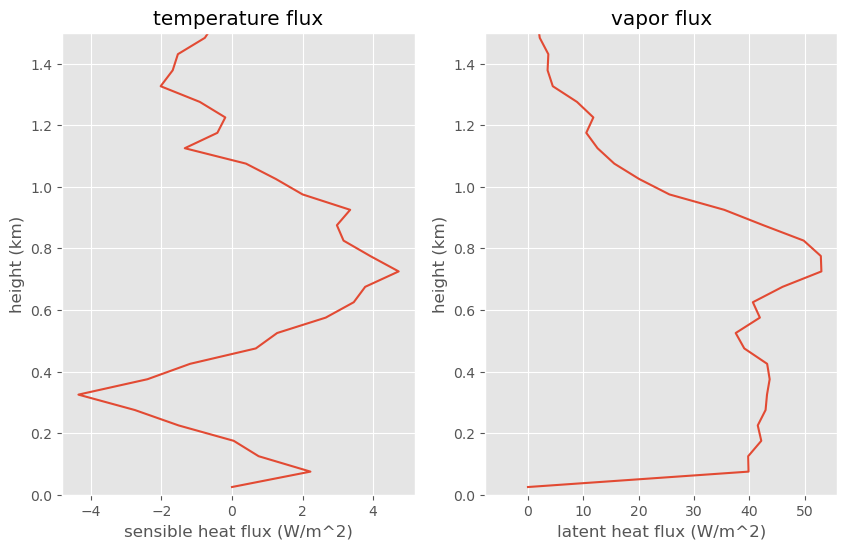

In [9]:
fig,ax=plt.subplots(1,2,figsize=(10,6))
ax[0].plot(T_flux_1d,the_height*meter2km)  
ax[0].set(xlabel='sensible heat flux (W/m^2)',ylabel='height (km)',title='temperature flux')
ax[1].plot(qv_flux_1d,the_height*meter2km)  
out=ax[1].set(xlabel='latent heat flux (W/m^2)',ylabel='height (km)',title='vapor flux')
out=[the_ax.set(ylim=(0,1.5)) for the_ax in ax]

### As expected, vapor transport dominates the energy flux in the warm marine boundary layer

### Closer examination of fluxes at 800 m

1\.  Look at simple histograms at one level

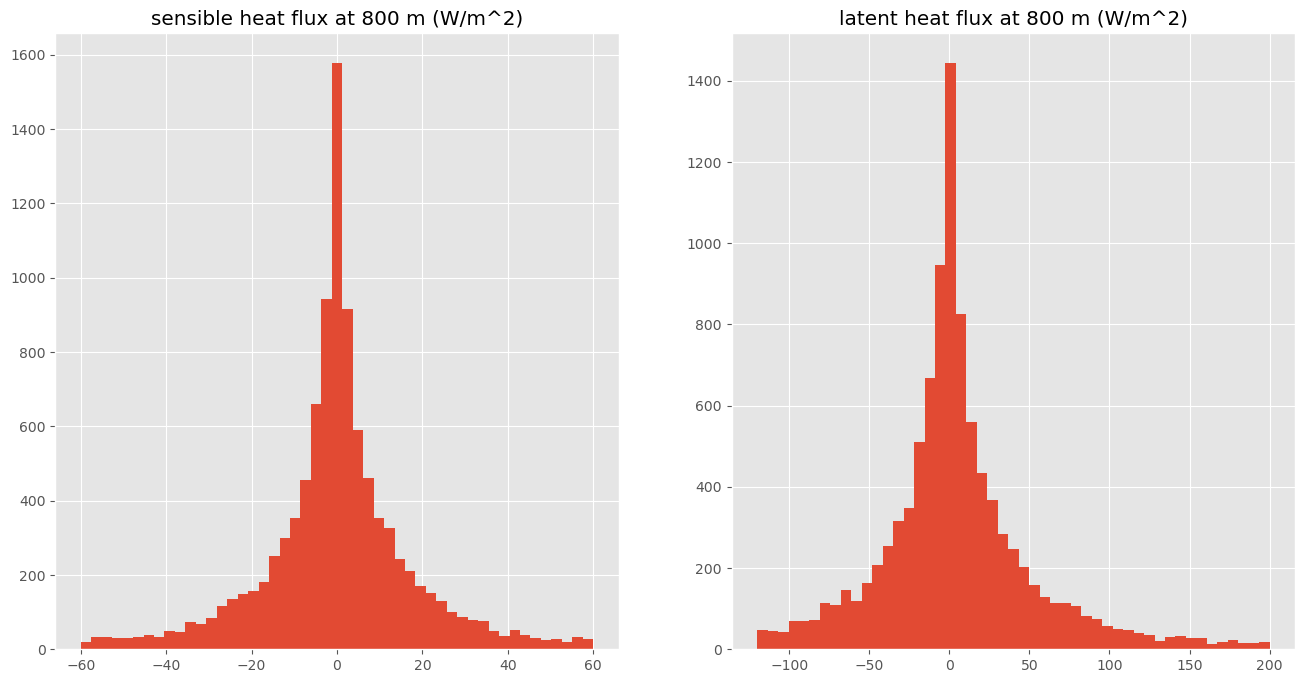

In [10]:
#
# select the level closest to 800 meters
# using searchsorted
#
zlev=np.searchsorted(the_height,800)
ql_800 = ql[zlev,:,:] == 0.
T_flux_800 = T_flux[zlev,:,:] #W/m^2
qv_flux_800 = qv_flux[zlev,:,:] #W/m^2
fig,ax = plt.subplots(1,2,figsize=(16,8))
out=ax[0].hist(T_flux_800.data.flat,bins=np.linspace(-60,60,50))
out=ax[1].hist(qv_flux_800.data.flat,bins=np.linspace(-120,200,50))
ax[0].set(title='sensible heat flux at 800 m (W/m^2)')
ax[1].set(title='latent heat flux at 800 m (W/m^2)');

### now do the same for the turbulent fluxes at that level in W/m^2

<xarray.DataArray ()>
array(3.1617892, dtype=float32)
Coordinates:
    z        float32 825.0
    time     float32 0.29
<xarray.DataArray ()>
array(49.82005, dtype=float32)
Coordinates:
    z        float32 825.0
    time     float32 0.29


[Text(0.5, 0, 'temperature flux (W/m^2) at 800 m')]

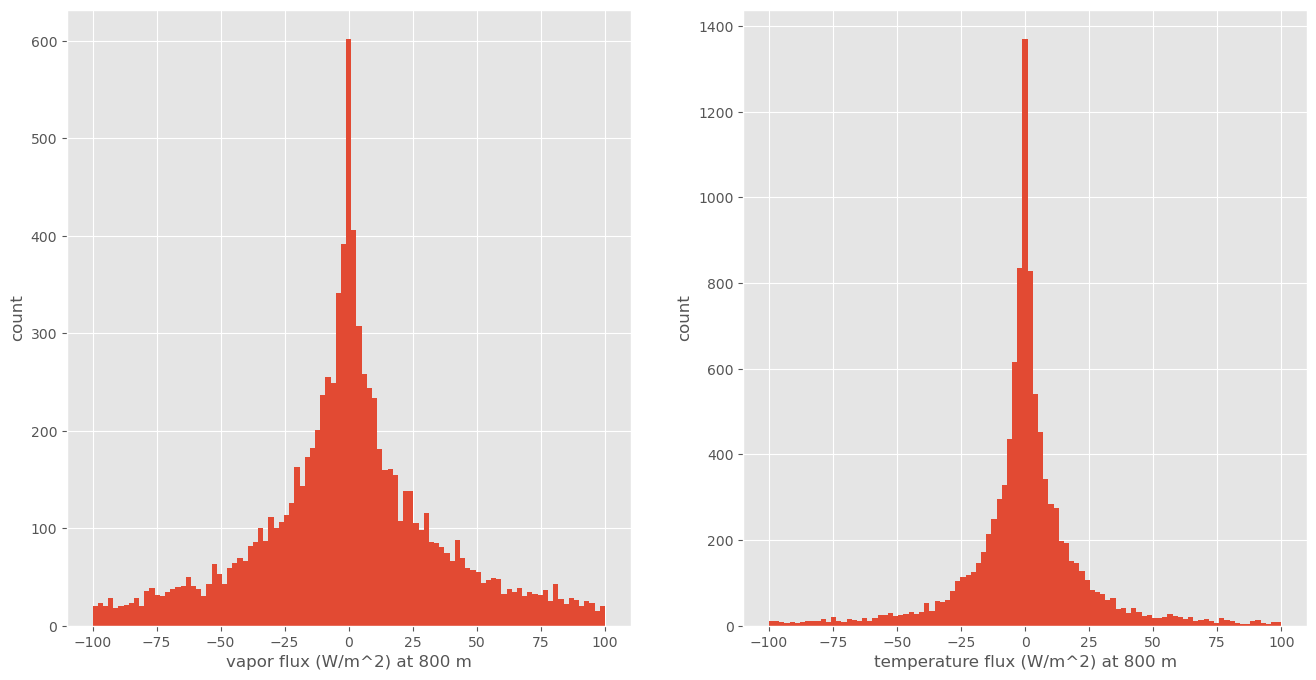

In [11]:
wpert_800=w_perturb[zlev,...]
Tpert_800=temp_perturb[zlev,...]
qvpert_800 = qv_perturb[zlev,...]
T_flux800=((wpert_800*Tpert_800)*rho_avg[zlev])*cpd  #W/m^2
qv_flux800=((wpert_800*qvpert_800)*rho_avg[zlev])*lv #W/m^2
print(T_flux800.mean())
print(qv_flux800.mean())
fig,ax=plt.subplots(1,2,figsize=(16,8))
out=ax[0].hist(qv_flux800.data.flat,bins=np.linspace(-100,100,100))
out=ax[1].hist(T_flux800.data.flat,bins=np.linspace(-100,100,100))
[item.set(ylabel='count') for item in ax]
ax[0].set(xlabel='vapor flux (W/m^2) at 800 m')
ax[1].set(xlabel='temperature flux (W/m^2) at 800 m')

###  But there are some gridcells with huge flux values

Here's what happens when I don't limit the flux ranges

[Text(0.5, 0, 'latent heat flux (W/m^2)'),
 Text(0, 0.5, 'sensible heat flux (W m^2)')]

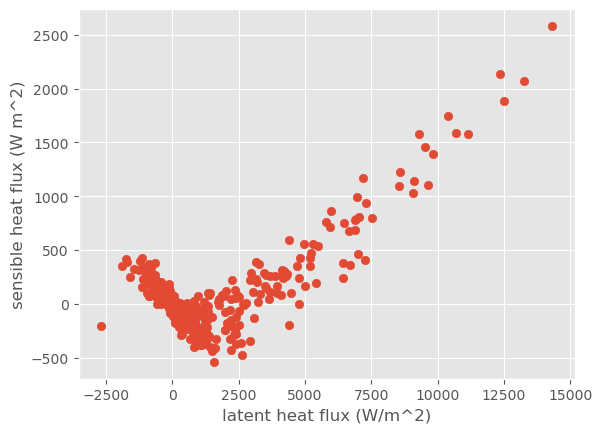

In [12]:
fig,ax=plt.subplots(1,1)
ax.scatter(qv_flux800.data.flat,T_flux800.data.flat)
ax.set(xlabel=r'latent heat flux (W/m^2)',ylabel=r'sensible heat flux (W m^2)')

### find the large  flux values

In [13]:
out=np.where(np.logical_and(qv_flux800 > 1000., T_flux800 > 1000))
#
#  unpack out into two individual lists and zip, then turn back
#  into a list
#
flux_list=list(zip(*out))
for item in flux_list:
    print(item)

(8, 88)
(27, 3)
(37, 4)
(37, 5)
(38, 4)
(39, 4)
(46, 13)
(47, 0)
(48, 37)
(48, 38)
(53, 20)
(53, 32)
(61, 43)
(70, 33)
(89, 33)
(91, 31)


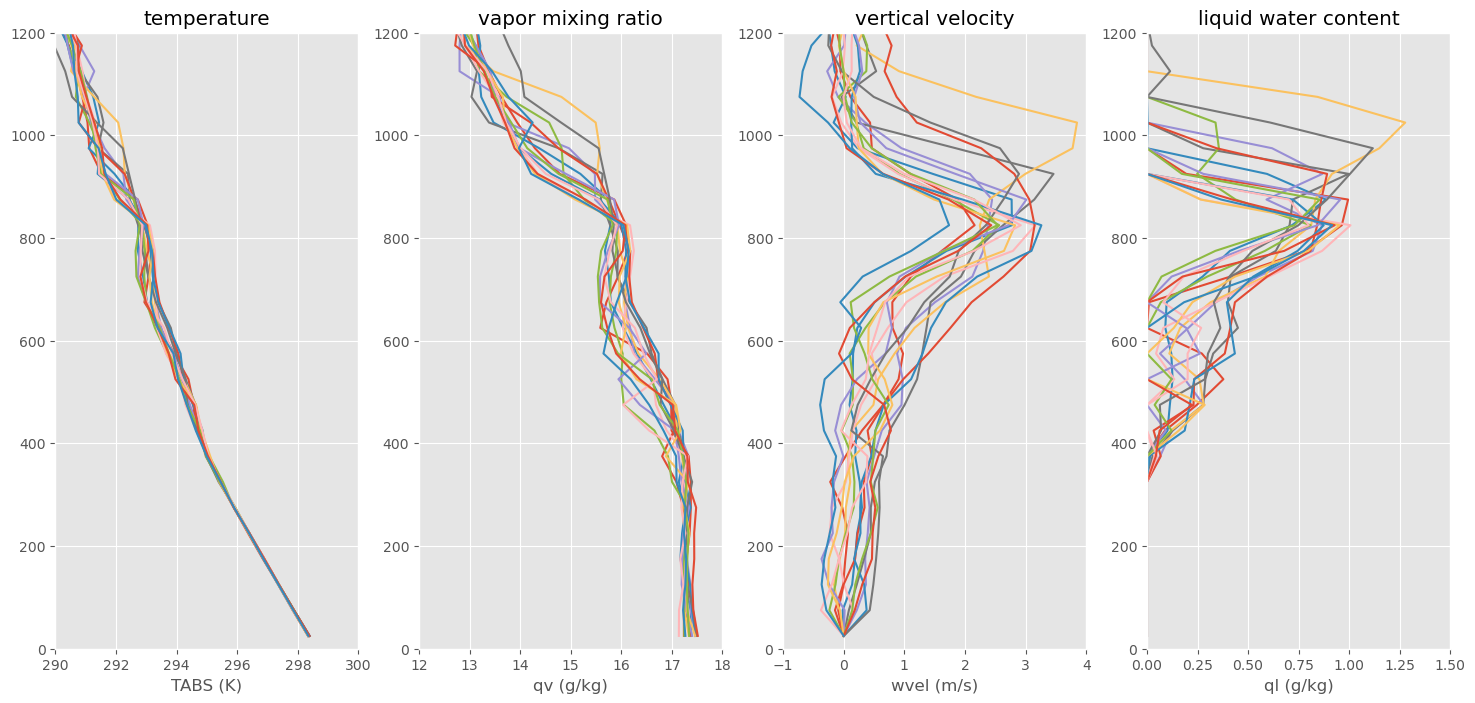

In [14]:
fig,ax=plt.subplots(1,4,figsize=(18,8))
for y,x in flux_list:
    ax[0].plot(the_temp[:,y,x],the_height)
    ax[1].plot(qv[:,y,x],the_height)
    ax[2].plot(wvel[:,y,x],the_height)
    ax[3].plot(ql[:,y,x],the_height)
ax[0].set(xlim=(290,300),xlabel='TABS (K)',title='temperature')
ax[1].set(xlim=(12,18),xlabel='qv (g/kg)',title='vapor mixing ratio')
ax[2].set(xlim=(-1,4),xlabel='wvel (m/s)',title='vertical velocity')
ax[3].set(xlim=(0,1.5),xlabel='ql (g/kg)',title='liquid water content')
out=[the_ax.set(ylim=(0,1200)) for the_ax in ax]

###  Conclusion: these large fluxes are coming from cloudy grid cells with coherent updrafts

They can't really be treated by Reynold's averaging.  We'll look at this in more detail later in the course